In [1]:
#라이브러리 로드
import numpy as np
import pandas as pd
import cv2
import os
import random
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

from colorsys import rgb_to_hsv
from keras.preprocessing.image import load_img

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

## 0. 상숫값 및 경로 설정

In [95]:
image_dir = 'images/' #1.이미지 불러오기 - 이미지 폴더 디렉토리
sample_ratio = 0.05 #1.이미지 불러오기 - 샘플링 비율
pca_threshold = 0.95 #3. PCA - 적합한 차원 수 찾기
save_dir = 'saves/' #6. 데이터 저장 - 데이터 저장 디렉토리

## 1. 이미지 불러오기

In [168]:
# 파일명을 담는 리스트
file_names = []

with os.scandir(image_dir) as files:
    for file in files:
        # .jpg .png 등 확장자명이 'g'로 끝나는 파일들 모두 읽기
        if file.name.endswith('g'):
            file_names.append(image_dir + file.name)
            
# 샘플링 수행 ()
sample_ratio = 0.05
if sample_ratio < 1:
    file_names = random.sample(file_names, int(len(file_names) * sample_ratio))

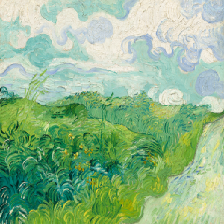

In [169]:
img = load_img(file_names[0], target_size = image_size)
img

## 2. RGB-HSV 데이터 추출

In [170]:
def extract_data(file_name, image_size = (224, 224)):
    #이미지 불러오기 및 np array로 변경
    img = load_img(file_name, target_size = image_size)
    img = np.array(img)
    img = img.reshape(image_size[0] * image_size[1], 3)
    
    #hsv 데이터 추출, 병합
    hsv_data = []
    for pixel in img:
        hsv_data.append(rgb_to_hsv(pixel[0] / 255, pixel[1] / 255, pixel[2] / 255))
    return np.concatenate((img / 255, hsv_data), axis = 1)

## 3. PCA - 적합한 차원 수 찾기

In [171]:
# 가장 적합한 차원 수를 찾기 위한 과정, explained_variance_ratio_ > 0.99 로 잡음

def pca_test(data, threshold, ):
    pca = PCA(n_components = len(data[0]), random_state = 2021)
    pca.fit_transform(data)
    
    ratio = np.cumsum(pca.explained_variance_ratio_)
    d = np.argmax(ratio >= threshold) + 1    
    return (d, ratio[d - 1])

In [172]:
data = extract_data(file_names[0])
pca_component = pca_test(data, pca_threshold)
pca_component

(4, 0.9941209996888865)

## 4. 클러스터링 수행

In [173]:
def clustering_data(data, pca_components = 5, target_cluster = 20):
    pca = PCA(n_components=pca_components, random_state=22)
    x = pca.fit_transform(data)
    
    kmeans = KMeans(n_clusters=target_cluster, random_state=22)
    kmeans.fit(x)
    
    return np.concatenate((data, kmeans.labels_.reshape(-1, 1)), axis = 1)

In [174]:
clu_data = clustering_data(data, pca_component[0])
clu_data[0:5]

array([[ 0.91764706,  0.8627451 ,  0.76470588, ...,  0.16666667,
         0.91764706, 14.        ],
       [ 0.90588235,  0.85098039,  0.75294118, ...,  0.16883117,
         0.90588235, 14.        ],
       [ 0.91764706,  0.88235294,  0.81568627, ...,  0.11111111,
         0.91764706, 14.        ],
       ...,
       [ 0.78431373,  0.8       ,  0.65882353, ...,  0.17647059,
         0.8       ,  1.        ],
       [ 0.76862745,  0.8       ,  0.64705882, ...,  0.19117647,
         0.8       ,  1.        ],
       [ 0.80392157,  0.8       ,  0.65098039, ...,  0.1902439 ,
         0.80392157,  1.        ]])

## 5. 클러스터 그룹 별 개수 세기

In [175]:
def grouping_clusters(data):
    table = pd.DataFrame(data, columns = ['R','G','B','H','S','V','Cluster'])
    gr = table.groupby('Cluster')
    gr = pd.concat([gr.mean(), gr['R'].count().rename('Count')], axis = 1)
    gr.sort_values(by = 'Count', ascending = False, inplace = True)
    
    scaler = MinMaxScaler()
    gr[['Count']] = scaler.fit_transform(gr[['Count']])
    return gr

In [176]:
gr_data = grouping_clusters(clu_data)
gr_data.head(5)

,R,G,B,H,S,V,Count
Cluster,,,,,,,
14.0,0.910079,0.896546,0.834760,0.142028,0.084984,0.912315,1.000000
5.0,0.678707,0.819247,0.758510,0.424685,0.171464,0.819247,0.733241
3.0,0.802301,0.863869,0.807167,0.338618,0.079646,0.863869,0.387871
8.0,0.438686,0.640760,0.289306,0.263443,0.548517,0.640760,0.374741
0.0,0.442232,0.657537,0.447219,0.335282,0.362066,0.657650,0.312370
4.0,0.275201,0.534472,0.244784,0.318338,0.570244,0.534472,0.275397
19.0,0.568251,0.768192,0.717158,0.455806,0.263137,0.770952,0.256220
1.0,0.786173,0.839687,0.702239,0.229504,0.165424,0.842099,0.255183
18.0,0.424547,0.615824,0.165391,0.239163,0.731578,0.616501,0.249136


## 6. 데이터 시각화

<BarContainer object of 20 artists>

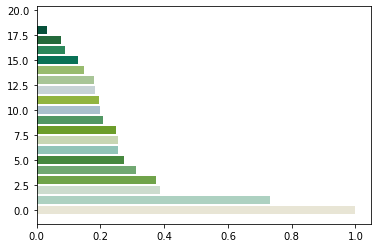

In [177]:
plt.barh(range(20), gr_data['Count'].values, color = gr_data.iloc[:, 0:3].values)

## 6. 데이터 저장

In [178]:
def save_data(data, file_name, save_dir):
    save_name = save_dir + file_name.rsplit('.')[0].rsplit('/')[-1] + ".csv"
    data.to_csv(save_name)

In [179]:
save_data(gr_data, file_names[0], "saves/")

## 7. 전체 데이터셋 수행

In [181]:
for file_name in tqdm(file_names):
    data = extract_data(file_name)
    pca_component = pca_test(data, pca_threshold)
    clu_data = clustering_data(data, pca_component[0])
    gr_data = grouping_clusters(clu_data)
    save_data(gr_data, file_name, save_dir)

100%|████████████████████████████████████████████████████████████████████████████████| 544/544 [19:01<00:00,  2.10s/it]
